## Python script to sort out the airfoil points

Purpose of our project : <br>
Intersted to find the quantitative agreement between numerical and experimental methods for the thrust generated by 
an RC Propeller

For this tried reverse engineering approach, by 

1. Scanning the RC propeller 
2. Extracting the airfoil profiles from the CAD geometry (this is in ParaView)
3. Sorting the points using a python script
4. Feeding the points in C81Gen to get the airfoil tables (These contain a variation of Mach no. and Re. no. for a different angle of attacks )
5. Using RotCFD for finding the thrust generated by the airfoils

In this post, am not going to cover all the above points, but just 3 rd point, i.e. pre-processing,
sorting the airfoil points and also normalizing the points such that the format is accepted by C81Gen software

The RC propeller ordered from market looks something like this

![](propeller.png)

Had to get this propeller scanned. And which looks something like this 
![](scanned.png)

Using ParaView extracted the airfoil profiles from this CAD model
![](extracted3.png)

Numerical simulations are done in [RotCFD](http://sukra-helitek.com/rotcfd.html) <br>
It works on momentum source method. So, instead of feeding the CAD geometry of the propeller, we need to feed the
airfoil properties and airfoil tables


Airfoil tables are generated by feeding the airfoil profiles in C81Gen

So, for feeding the airfoil profiles, that are extracted from the ParaView, are not in order. <br>
I think you understand this better if you see the airfoil points plotted, which is done below

So to sort out what is the neighboring point of the airfoil points, python script is used and this is automated. <br>
Here, in the current post, we'll just look at the script in sorting the order of the points. to find the neighbour point by measuring distance between points.

If you are lost, what this is all about, just ignore all this and consider the take home from the post is python script 
for reading the airfoil points (or can be any other section) and sorting them in order. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

num='545'  #this is just the section number I gave for this particular airfoil profile 
f=open('parafoil_'+num+'.csv','r')

Will provide the airfoil profile and the csv file in github link

In [2]:
#For output

write=open('output','w')

f1=f.name 

In [3]:
f1 = f.name.replace('.csv','')

# f2='.csv'
# for char in f2:
#     f1=f1.replace(char,"")

f2=f1+'_deg'
# f3=f1+'_pts'
f4=f1+'_pts_rot'
deg_output=open(f2,'w')
# points_output=open(f3,'w')
# points_output1=open(f4,'w')
# points_output2=open('axis_shift','w')
out=open(f4,'w')

In [4]:
f4

'parafoil_545_pts_rot'

In [5]:
num_lines = sum(1 for line in open('parafoil_'+num+'.csv'))
lines=f.readlines()[1:num_lines]
print('Number of lines : {}'.format(num_lines))

Number of lines : 400


Create empty arrays

In [6]:
dataset_num=num_lines-1  #Leaving the header line 

arX=[None]*dataset_num
arY=[None]*dataset_num

In [7]:
sin=math.sin
cos=math.cos

In [8]:
array=np.loadtxt(lines,dtype='str',delimiter=',')

for i in range(dataset_num):
    arX[i]=float(array[i][0])
    arY[i]=float(array[i][1])


'Length of array {}'.format(len(arX))

'Length of array 399'

Image size and style settings

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

plt.style.use('ggplot')

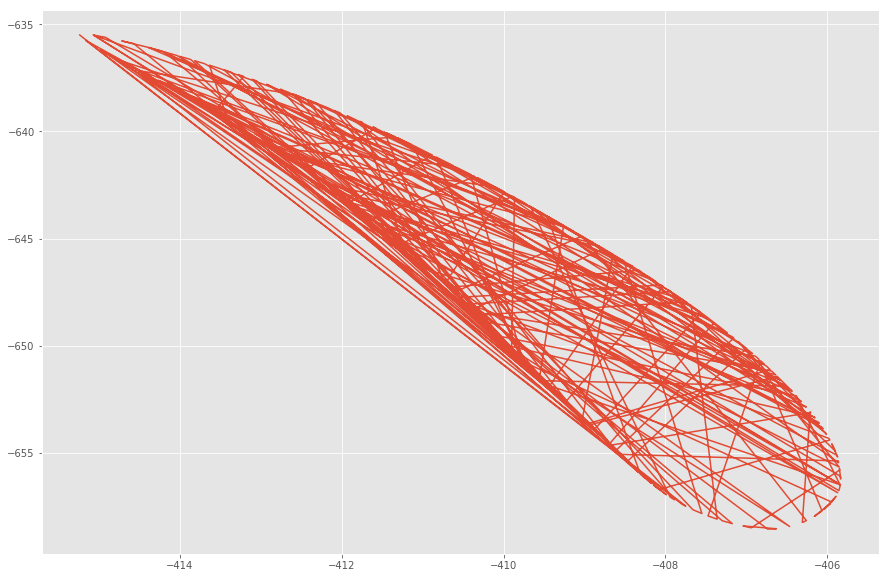

In [10]:
import matplotlib.pyplot as plt
plt.plot(arX,arY,'-')
plt.show()

If we join the points in order, that's how they are connected <br>
So, they are not in order, now we need to sort them in order

We ll choose some point, we can choose any point, say we ll chose that has x_max

In [11]:
fptIn=arX.index(max(arX))  #first point Index
aptIn=arX.index(min(arX))  #aft point Index

# for i in range(dataset_num):
# print(fptIn)

# arX[fptIn]
# print(len(arX))

# arX[aptIn]
'First and aft point indices are : {},{}'.format(fptIn, aptIn)

'First and aft point indices are : 125,0'

Now we start sorting the points by the distance and saving their indices

In [12]:
adjIn=[None]*dataset_num  #adjacent points indices
# adjIn=arX[:]
# adjIn.append(fptIn)
# adjIn.insert(0,fptIn)
adjIn[0]=fptIn #arXfptIn
# print(adjIn[0])


for j in range(dataset_num-1):
    temp=10000
    for i in range(dataset_num):
        if i not in adjIn:

            dist=math.hypot(arX[adjIn[j]]-arX[i],arY[adjIn[j]]-arY[i])
            if dist<temp:
                temp=dist
                index=i
                print(index,i,'inner',file=write)
        else:
            print(j,i,adjIn.index(i),'else',file=write)
    print(index,temp,'index',file=write)
    adjIn[j+1]=index
    

        
    
# write.close()

Now fill the array with the indices we found

In [13]:
arX1=[None]*dataset_num
arY1=[None]*dataset_num

for i in range(dataset_num):
    arX1[i]=arX[adjIn[i]]
    arY1[i]=arY[adjIn[i]]    

Checking the front and aft points (Just out of curiousity)

In [14]:
fptIn1=arX1.index(arX[fptIn])
aptIn1=arX1.index(arX[aptIn])

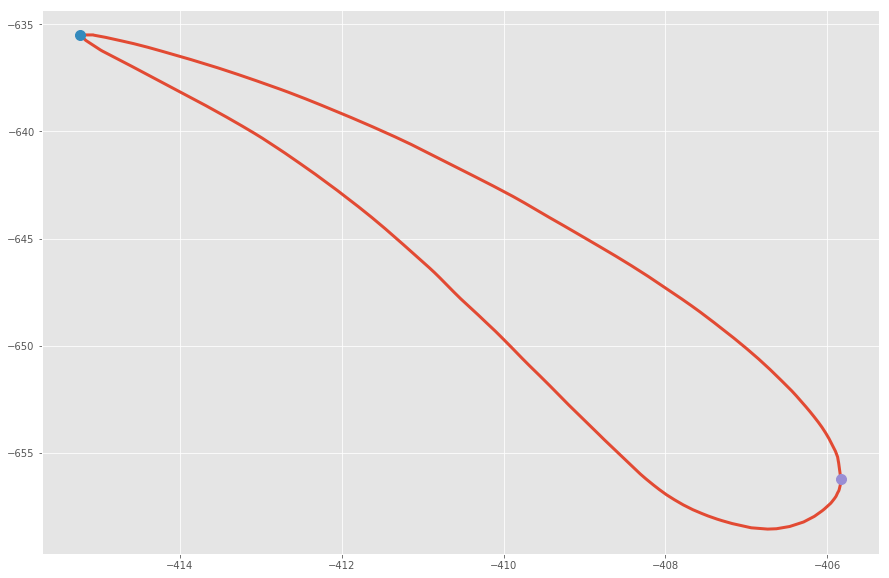

In [15]:
plt.plot(arX1,arY1,'-',linewidth=3)
plt.plot(arX1[aptIn1],arY1[aptIn1],'o' ,markersize = 10)  #This is the front point
plt.plot(arX1[fptIn1],arY1[fptIn1],'o', markersize = 10)  #This is the aft point
plt.show()

We ordered the points, now we need to find the chord line and rotate the chord line so, the angle of attack of the 
airfoil zero

#### Finding chord length

In [16]:
#Finding distance between all points
dsq=[None]*dataset_num
dsq1=[None]*dataset_num
# i11=[None]*dataset_num
j11=[None]*dataset_num

for i in range(dataset_num):
    temp=0
    for j in range(dataset_num):
        dsq[j]=(arY1[i]-arY1[j])**2+(arX1[i]-arX1[j])**2
        if dsq[j]>temp:
            temp=dsq[j]
            j1=j 

    dsq1[i]=temp #saving the max. distance for each point in this array
    j11[i]=j1


In [17]:
#Chord length
chordL=math.sqrt(max(dsq1))
print(round(chordL,3))


24.594


In [18]:
chordP1I= dsq1.index(max(dsq1))
chordP2I=j11[chordP1I]
print(chordP1I, chordP2I)

178 380


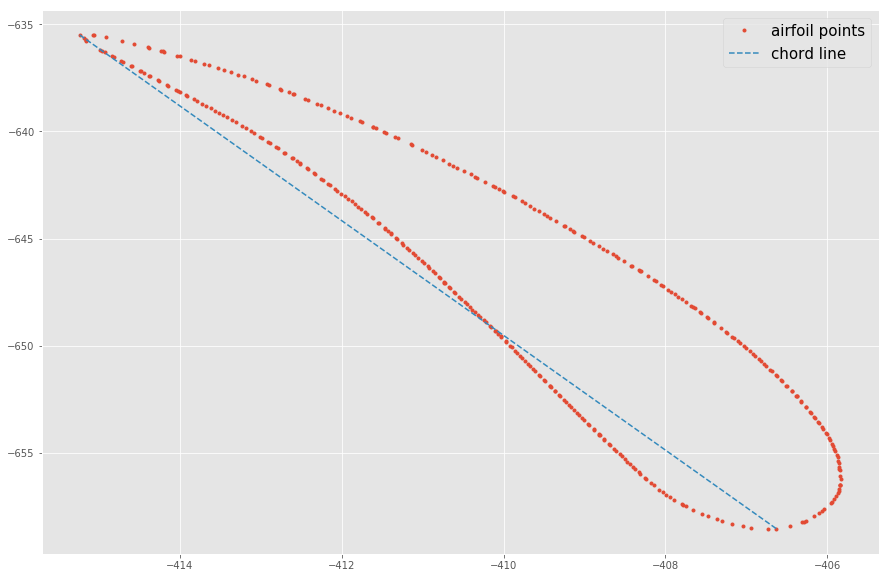

In [19]:
plt.plot(arX1,arY1,'.', label='airfoil points')
plt.plot([arX1[chordP1I],arX1[chordP2I]],[arY1[chordP1I],arY1[chordP2I]],'--' ,label='chord line')
plt.legend(fontsize=15)
plt.show()

Now we have chord line <br>
We need to find which one is leading and trailing edge <br>
We make an assumption here, point closure to origin is trailing edge

In [20]:
#checking chordP1I or chordP2I is closure to origin
d1=math.hypot(arY[chordP1I],arX[chordP1I] )
d2=math.hypot(arY[chordP2I],arX[chordP2I] )
print(d1,d2)

if d1<d2:
    chordMin=chordP1I
    chordMax=chordP2I
else:
    chordMin=chordP2I
    chordMax=chordP1I

770.4901631561409 766.053784210967


Now moving all the points to axis, i.e. moving chordMax point to origin

In [21]:
arX2=arX1[:]
arY2=arY1[:]
for i in range(len(arX1)):
    arX2[i]=arX1[i]-arX1[chordMax]
    arY2[i]=arY1[i]-arY1[chordMax]

Now we find the angle the chord line is making with x-axis and turn the entire airfoil points

In [22]:
#Slope of chord line
cSlope=arY2[chordMin]/arX2[chordMin]  #Since other end is at the origin

# # #Turning axis
theta=(math.atan(cSlope))     #in radians
# theta=180+theta
# theta=math.pi-theta
print('Slope:',cSlope)
# print(arX2[chordMax],arY2[chordMax])
print('Angle in theta :',math.degrees(theta))

Slope: -2.675269596400889
Angle in theta : -69.50455328234997


Now turning all the points with this angle

In [23]:
arX3=arX1[:]
arY3=arY1[:]


if cSlope<0:
    n=-1
else:
    n=1


for i in range(len(arX1)):
    arX3[i]=n*(arX2[i]*cos(-theta) - arY2[i]*sin(-theta))
    arY3[i]=-n*(arX2[i]*sin(-theta) + arY2[i]*cos(-theta))

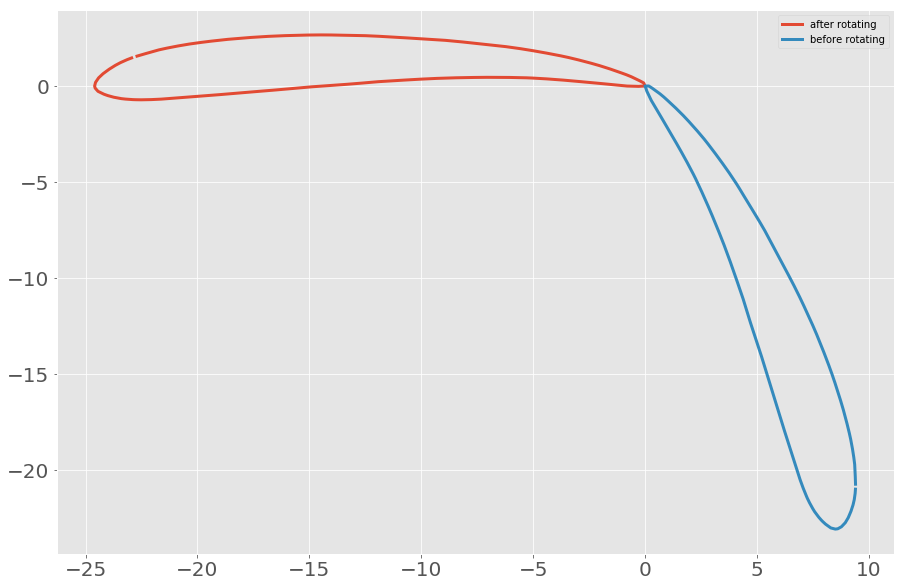

In [25]:
plt.plot(arX3,arY3,'r-',color='C0',linewidth=3, label='after rotating')
plt.plot(arX2,arY2,'-', color='C1', linewidth=3, label='before rotating')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.show()

Now normalizing chord

In [26]:
for i in range(len(arX3)):
    arX3[i]/=chordL
    arY3[i]/=chordL

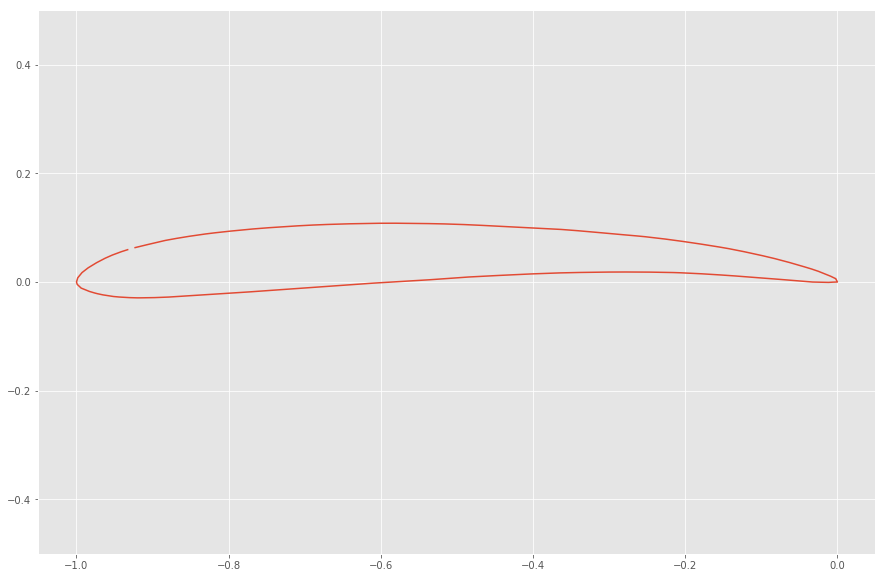

In [31]:
plt.plot(arX3,arY3,'-')
plt.ylim(-0.5,0.5)
plt.show()

Writing to file the modified points, twist and chord length of the airfoil

In [29]:
for i in range(len(arX3)):
    print(arX3[i],arY3[i],file=out)
    

print('Twist = ',round(theta,5),file=deg_output)
print('chord length = ',round(chordL,5),file=deg_output)
    
out.close()
deg_output.close()

We can also try something like fitting a line to the points

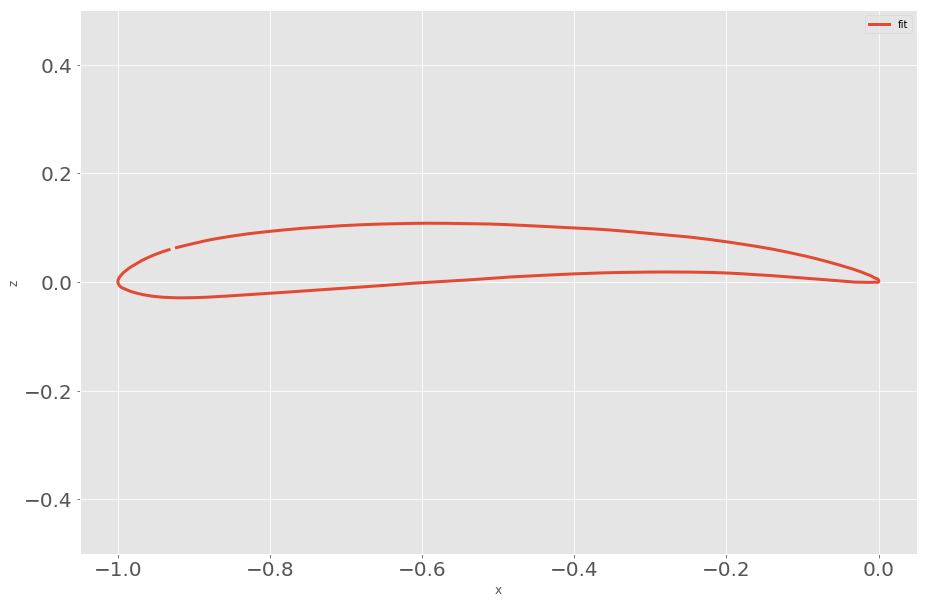

In [30]:
from numpy import arange, cos, linspace, pi, sin, random
from scipy.interpolate import splprep, splev

x=arX3
z=arY3


# spline parameters
s=0 # smoothness parameter
k=2 # spline order
nest=0 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tckp,u = splprep([x,z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,znew = splev(linspace(0,1,1000),tckp)

import pylab


pylab.plot 
# data,=pylab.plot(x,z,'bo-',label='data')
fit,=pylab.plot(xnew,znew,'-',label='fit', linewidth=3)
pylab.legend()
pylab.xlabel('x')
pylab.ylabel('z')
pylab.ylim(-0.5,0.5)
pylab.xticks(fontsize=20)
pylab.yticks(fontsize=20)

pylab.show()